# First let's load the libraries and the model

In [186]:
from langchain_community.llms import Ollama
from langchain.memory import ConversationBufferWindowMemory
from langchain.chains import ConversationChain
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool

model = ChatOllama(
    model = 'llama3.1',
    temperature = 0,
)

# We want to see if the LLM with tools can be used over a dataset and how well it can operate with said tools to accomplish a model benchmark

We want to use a Google Play Store dataset for this project, where we will throw some sklearn models to be able to look for what model predicts the best over our dataset features.

All of the project's files can be found at: https://github.com/catalindoja/ollama_langgraph_langchain_project

In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("google_play_store_dataset.csv")
df_cleaned = df
print(df.head())

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

# Auxiliar functions that will help us clean the dataset using tool calling and the LLM Llama3.1

To avoid issues we will need to define as global the dataframe.
During the tool execution flow, we had a lot of issues with the variable "df" and "df_cleaned" not being recognized.

In [188]:
def expand_genres():
    global df
    # Split the "Genres" column by ';' and expand into separate columns
    genres_split = df['Genres'].str.split(';', expand=True)
    
    # Determine the maximum number of genres in any row
    max_genres = genres_split.shape[1]
    
    # Create new column names and assign for the split genres
    genres_split.columns = [f'Genre{i+1}' for i in range(max_genres)]
    
    # Merge the new genre columns back into the original dataframe
    df = pd.concat([df, genres_split], axis=1)
    
    df.fillna('None', inplace=True)
    df.drop('Genres', axis=1, inplace=True)

def clean_size(size):
    """Convert sizes like '19M', '14k' to floats (MB)."""
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))  # Return size in MB
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024  # Convert kB to MB
    return np.nan  # Handle non-convertible cases

def clean_installs(installs):
    """Convert '10,000+' to int by removing commas and '+' sign."""
    if isinstance(installs, str):
        # Remove commas and plus signs
        installs = installs.replace(',', '').replace('+', '')
        try:
            return int(installs)  # Convert to integer
        except ValueError:
            return np.nan  # Return NaN for non-numeric entries like 'Free'
    return np.nan

def clean_price(price):
    """Convert price like '$0.99' to numeric (float)."""
    if isinstance(price, str):
        if price.lower() == 'free':
            return 0.0

        # Remove '$' and any commas
        price = price.replace('$', '').replace(',', '')
        try:
            return float(price)  # Convert to float
        except ValueError:
            return np.nan  # Return NaN for non-numeric entries (e.g., 'Free')
    return np.nan  # In case of invalid or missing data

# The definition of our tools

To avoid issues we will need to define as global the dataframe.
During the tool execution flow, we had a lot of issues with the variable "df" and "df_cleaned" not being recognized.

There's a limit on the head of the dataframe of 10 to not go overboard with the prints sizes.

In [189]:
from langchain_core.tools import tool

@tool
def load_dataset() -> str:
    """Load the dataset into memory"""
    global df
    df = pd.read_csv("google_play_store_dataset.csv")
    return "Loaded the dataframe into memory"

@tool
def check_amount_of_nulls() -> str:
    "Check how many null values are there in the dataset"
    nan_counts = df.isnull().sum()
    nan_percentages = (df.isnull().sum() / len(df)) * 100
    
    nan_summary = pd.DataFrame({
        'Null Count': nan_counts,
        'Null Percentage': nan_percentages
    })

    return nan_summary.to_string()

@tool
def get_null_rows() -> str:
    """
    Returns rows from the DataFrame where any column has a null value.
    The result is returned as a CSV string for easy communication.
    """
    null_rows = df[df.isnull().any(axis=1)]
    return null_rows.head(10).to_csv(index=False)

@tool
def clean_null_values() -> str:
    "Clean the dataset of the null values"
    global df  # Use the global `df`
    global df_cleaned
    
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

    #The idea is to take the median rating if it has any reviews. If it doesn't,
    #then we just put a 0 as a rating for the app.
    median_rating = df[df['Reviews'] > 0]['Rating'].median()
    
    def fill_rating(row):
        if pd.isna(row['Rating']):
            if row['Reviews'] == 0:
                return 0
            else:
                return median_rating
        else:
            return row['Rating']

    df['Rating'] = df.apply(fill_rating, axis=1)

    # handle the rest of the null values and duplicated values
    df.duplicated().sum()
    df = df.drop_duplicates()
    df = df.dropna()

    # we use the auxiliar function to expand the genres into 2.
    expand_genres()
    
    df_cleaned = df.dropna()
    
    # We define groups where each category lies
    category_mapping = {
        'SOCIAL': 'HEALTH',
        'BEAUTY': 'HEALTH',
        'MEDICAL': 'HEALTH',
        'HEALTH_AND_FITNESS': 'HEALTH',
        'ART_AND_DESIGN': 'ENTERTAINMENT',
        'AUTO_AND_VEHICLES': 'ENTERTAINMENT',
        'COMICS': 'ENTERTAINMENT',
        'ENTERTAINMENT': 'ENTERTAINMENT',
        'EVENTS': 'ENTERTAINMENT',
        'LIBRARIES_AND_DEMO': 'ENTERTAINMENT',
        'MUSIC_AND_AUDIO': 'ENTERTAINMENT',
        'VIDEO_PLAYERS': 'ENTERTAINMENT',
        'BOOKS_AND_REFERENCE': 'EDUCATION',
        'PARENTING': 'EDUCATION',
        'EDUCATION': 'EDUCATION',
        'BUSINESS': 'BUSINESS',
        'FINANCE': 'BUSINESS',
        'PRODUCTIVITY': 'BUSINESS',
        'DATING': 'LIFESTYLE',
        'FOOD_AND_DRINK': 'LIFESTYLE',
        'HOUSE_AND_HOME': 'LIFESTYLE',
        'LIFESTYLE': 'LIFESTYLE',
        'SHOPPING': 'LIFESTYLE',
        'PERSONALIZATION': 'LIFESTYLE',
        'WEATHER': 'LIFESTYLE',
        'TRAVEL_AND_LOCAL': 'LIFESTYLE',
        'COMMUNICATION': 'TECHNOLOGY',
        'TOOLS': 'TECHNOLOGY',
        'NEWS_AND_MAGAZINES': 'TECHNOLOGY',
        'MAPS_AND_NAVIGATION': 'TECHNOLOGY',
        'FAMILY': 'LIFESTYLE',
        'PHOTOGRAPHY': 'ENTERTAINMENT',
        'GAME': 'ENTERTAINMENT',
        'SPORTS': 'LIFESTYLE'
    }
    
    
    # Apply the mapping to the 'Category Name' column
    df_cleaned['Category Name'] = df_cleaned['Category'].map(category_mapping).fillna(df_cleaned['Category'])

    # we need to clean the data and map it from non-numerical values to numerical ones.
    df_cleaned['Category'] = df_cleaned['Category'].astype('category').cat.codes
    df_cleaned['Type'] = df_cleaned['Type'].astype('category').cat.codes
    df_cleaned['Content Rating'] = df_cleaned['Content Rating'].astype('category').cat.codes
    df_cleaned['Genre1'] = df_cleaned['Genre1'].astype('category').cat.codes
    df_cleaned['Genre2'] = df_cleaned['Genre2'].astype('category').cat.codes
    df_cleaned['Size'] = df_cleaned['Size'].map(clean_size)
    df_cleaned['Installs'] = df_cleaned['Installs'].map(clean_installs)
    df_cleaned['Last Updated'] = pd.to_datetime(df_cleaned['Last Updated'], errors='coerce')
    df_cleaned['Last Updated'] = df_cleaned['Last Updated'].apply(lambda x: x.to_julian_date() if pd.notna(x) else np.nan)
    df_cleaned['Price'] = df_cleaned['Price'].map(clean_price)

    # the categories will have null values after the conversion of the non numerical values
    # so we need to clean it again
    category_mean_size = df_cleaned.groupby('Category')['Size'].mean()

    def fill_size(row):
        if pd.isna(row['Size']):
            return category_mean_size[row['Category']]
        return row['Size']
    
    # Apply the function to the DataFrame
    df_cleaned['Size'] = df_cleaned.apply(fill_size, axis=1)
    return "Cleaned and normalized all of the Google Play Store dataset"

@tool
def get_models_score() -> str:
    """Executes a series of models to see which ones are better for the dataset and gets the scores of them"""

    global df_cleaned
        # We drop columns we believe will not positively affect our models and we select 'Rating' as our y variable
    X = df_cleaned.drop(columns=['Rating','Category Name','App','Current Ver','Android Ver'])
    y = df_cleaned['Rating']
    
    # We Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'Support Vector Regression': SVR(),
        'k-Nearest Neighbors': KNeighborsRegressor()
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    #Finally display the results
    results_df = pd.DataFrame(results).T
    return results_df.to_string()
    

# Let us check if the tool calling is being performed

What we look for right now is in the output of the messages. We need to find the tool_calls array and see if it actually calls all of the tools that we implemented.

In [190]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {
    "load_dataset": load_dataset,
    "check_amount_of_nulls": check_amount_of_nulls,
    "get_null_rows": get_null_rows,
    "clean_null_values": clean_null_values,
    "get_models_score": get_models_score
}

messages = [
    HumanMessage(
        "Could you load the dataset?"
    ),
    HumanMessage(
        "Could you check how many nulls there are in the dataset?"
    ),
    HumanMessage(
        "Could you show me some of the null rows?"
    ),
    HumanMessage(
        "Could you clean the dataset?"
    ),
    HumanMessage(
        "Could you execute the models and get the scores for the dataset?"
    )
]

llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='Could you load the dataset?', additional_kwargs={}, response_metadata={}), HumanMessage(content='Could you check how many nulls there are in the dataset?', additional_kwargs={}, response_metadata={}), HumanMessage(content='Could you show me some of the null rows?', additional_kwargs={}, response_metadata={}), HumanMessage(content='Could you clean the dataset?', additional_kwargs={}, response_metadata={}), HumanMessage(content='Could you execute the models and get the scores for the dataset?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-20T14:59:44.500714393Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6173147323, 'load_duration': 1757671657, 'prompt_eval_count': 381, 'prompt_eval_duration': 475000000, 'eval_count': 81, 'eval_duration': 3204000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-a58bedea-

# Check the tool outputs

Now we want to see if the outputs correspond to the tool calls, and we want to specifically see that no execution errors happened.

In [191]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    print("Tool output:", tool_output)
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

Tool output: Loaded the dataframe into memory
Tool output:                 Null Count  Null Percentage
App                      0         0.000000
Category                 0         0.000000
Rating                1474        13.596532
Reviews                  0         0.000000
Size                     0         0.000000
Installs                 0         0.000000
Type                     1         0.009224
Price                    0         0.000000
Content Rating           1         0.009224
Genres                   0         0.000000
Last Updated             0         0.000000
Current Ver              8         0.073794
Android Ver              3         0.027673
Tool output: App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
Learn To Draw Kawaii Characters,ART_AND_DESIGN,3.2,55,2.7M,"5,000+",Free,0,Everyone,Art & Design,"June 6, 2018",,4.2 and up
Mcqueen Coloring pages,ART_AND_DESIGN,,61,7.0M,"100,000+",Free,0,Everyone,Ar

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.14457e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Tool output:                                 MSE       MAE        R2
Linear Regression          1.061486  0.632363  0.008835
Ridge Regression           1.061485  0.632360  0.008836
Lasso Regression           1.057453  0.625214  0.012601
Decision Tree              0.373261  0.375604  0.651467
Random Forest              0.200927  0.289558  0.812384
Gradient Boosting          0.205251  0.300442  0.808346
Support Vector Regression  1.110501  0.523760 -0.036933
k-Nearest Neighbors        0.836600  0.530155  0.218822


AIMessage(content='The dataset has been loaded into memory.\n\nThere are null values in the \'Type\' and \'Content Rating\' columns, with a total of 2 null values.\n\nHere are some of the rows with null values:\n\n| App | Category | Rating | Reviews | Size | Installs | Type | Price | Content Rating | Genres | Last Updated | Current Ver | Android Ver |\n| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |\n| Learn To Draw Kawaii Characters | ART_AND_DESIGN | 3.2 | 55 | 2.7M | "5,000+" | None | Free | 0 | Everyone | Art & Design | June 6, 2018 | ,4.2 and up |\n| Mcqueen Coloring pages | ART_AND_DESIGN | None | 61 | 7.0M | "100,000+" | None | Free | 0 | Everyone; Action & Adventure | March 7, 2018 | 1.0.0,4.1 and up |\n\nThe dataset has been cleaned by removing the null values.\n\nThe models have been executed and their scores are as follows:\n\n* Linear Regression: MSE = 1.061486, MAE = 0.632363, R2 = 0.008835\n* Ridge Regression: MSE = 1.061485, MAE = 0.632360

# Lang Graph creation

First of all we will need the Agent State as it will be used by the graph functions.
It simply follows the Annotated Sequence BaseMessage schema.

In [192]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

llm_with_tools = model.bind_tools([load_dataset, check_amount_of_nulls, get_null_rows, clean_null_values, get_models_score])

# Definition of the node functions of the graph

In [193]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    print("Le last message: ", last_message)
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    # print("Tool output:", tool_output)
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message]}

# Definition of the graph workflow and compilation of it as an "app"

In [194]:
workflow = StateGraph(AgentState)
    
# Define nodes
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Define edges
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    lambda state: "action" if state["messages"][-1].tool_calls else END,
    {
        "action": "action",
        END: END
    }
)
workflow.add_edge("action", "agent")

app = workflow.compile()

# Visualize the graph

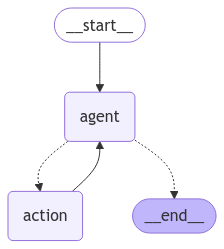

In [195]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

# Small test to see that the graph works and it calls the most basic tools.

In [196]:
from langchain_core.messages import SystemMessage

df = pd.read_csv("google_play_store_dataset.csv")

system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that."
)
human_message = HumanMessage(content="How many nulls are there in the dataset?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages})

Le last message:  content='' additional_kwargs={} response_metadata={'model': 'llama3.1', 'created_at': '2024-12-20T15:00:13.87099838Z', 'done': True, 'done_reason': 'stop', 'total_duration': 940869586, 'load_duration': 12515968, 'prompt_eval_count': 357, 'prompt_eval_duration': 329000000, 'eval_count': 16, 'eval_duration': 597000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-53a5e435-4450-4f70-ace4-9aa4a6bc3150-0' tool_calls=[{'name': 'check_amount_of_nulls', 'args': {}, 'id': '2a7f33b6-3d46-403a-8167-cfd535cc53e9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 357, 'output_tokens': 16, 'total_tokens': 373}


In [197]:
print(result["messages"][-1].content)

There are 1487 nulls in the dataset.


# Full fledged test where we simulate a chatbot workflow

Here we want to check that a normal chatbot worflow would work properly, but we also want to see that the model interprets the tools responses and it answers the user properly.

In [198]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# Initialize chat history with a system message
chat_history = [
    SystemMessage(content="You are responsible for answering user questions. You use tools for that.")
]

# Function to add a human message, get a response, and handle tool outputs
def ask_question(app, question, chat_history):
    # Append the user's question as a human message to chat history
    human_message = HumanMessage(content=question)
    chat_history.append(human_message)
    
    # Invoke the app with the full chat history to get a response with context
    result = app.invoke({"messages": chat_history})
    
    # Extract AI response content, handling empty content by checking tool output
    ai_content = result["messages"][-1].content
    
    ai_message = AIMessage(content=ai_content)
    print("ai_message: ", ai_message)
    chat_history.append(ai_message)
    
    # Return the response content for display
    return ai_content

# Example usage with multiple questions
questions = [
    "Could you load the dataset?",
    "How many nulls are there in the dataset?",
    "Could you show me some of the null rows?",
    "Could you clean the dataset?",
    "Could you execute the models and get the scores for the dataset?"
]

# Loop through questions to maintain conversation context in `chat_history`
for question in questions:
    response = ask_question(app, question, chat_history)
    print(f"Q: {question}\nA: {response}\n")

### is it possible that i should do a for on this messages array and add it in an orderly manner? similar to the example i saw in a video?
### what about a new node called router between agent and action?

Le last message:  content='' additional_kwargs={} response_metadata={'model': 'llama3.1', 'created_at': '2024-12-20T15:00:15.309754701Z', 'done': True, 'done_reason': 'stop', 'total_duration': 751994433, 'load_duration': 12607903, 'prompt_eval_count': 353, 'prompt_eval_duration': 260000000, 'eval_count': 13, 'eval_duration': 477000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-c751da94-b399-4b12-ad6d-38964d8cb747-0' tool_calls=[{'name': 'load_dataset', 'args': {}, 'id': 'd081aec7-645e-449f-9c8d-4f8be4fbde6f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 353, 'output_tokens': 13, 'total_tokens': 366}
ai_message:  content='The dataset has been loaded successfully. It is now available for further analysis and processing.' additional_kwargs={} response_metadata={}
Q: Could you load the dataset?
A: The dataset has been loaded successfully. It is now available for further analysis and processing.

Le last message:  content='' additional_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.14457e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


ai_message:  content='The scores for the dataset have been calculated using various machine learning models. The best performing model is Random Forest with an MSE of 0.198207, MAE of 0.286714, and R2 score of 0.814923.' additional_kwargs={} response_metadata={}
Q: Could you execute the models and get the scores for the dataset?
A: The scores for the dataset have been calculated using various machine learning models. The best performing model is Random Forest with an MSE of 0.198207, MAE of 0.286714, and R2 score of 0.814923.

